In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import re
import numpy as np
import random
from skimage import color
from skimage.color import rgb2lab, deltaE_ciede2000
import colorsys

In [2]:
# Folder setup
train_dir = 'train'
test_dir = 'test'

# Natural sort helper
def natural_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Image loader
def load_images_from_folder(folder, limit=None):
    images = []
    filenames = []
    count = 0
    for filename in sorted(os.listdir(folder), key=natural_key):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                images.append(img)
                filenames.append(filename)
                count += 1
                if limit and count >= limit:
                    break
    return images, filenames

In [3]:
# Hough line removal
def remove_lines_with_hough_enhanced(gray_img, binary_img):
    equalized = cv2.equalizeHist(gray_img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    enhanced = cv2.morphologyEx(equalized, cv2.MORPH_CLOSE, kernel)
    edges = cv2.Canny(enhanced, 30, 120)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=25, minLineLength=20, maxLineGap=10)
    cleaned = binary_img.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
            if 10 < abs(angle) < 170:
                cv2.line(cleaned, (x1, y1), (x2, y2), 255, 2)
    return cleaned

#  Morphological scratch line removal 
def remove_scratch_lines_morphological(binary_img):
    h_kernel = np.ones((1, 3), np.uint8)
    v_kernel = np.ones((3, 1), np.uint8)
    s_kernel = np.ones((2, 2), np.uint8)
    
    h_opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, h_kernel)
    v_opening = cv2.morphologyEx(h_opening, cv2.MORPH_OPEN, v_kernel)
    cleaned = cv2.morphologyEx(v_opening, cv2.MORPH_OPEN, s_kernel)

    closing_kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, closing_kernel)
    
    return cleaned

# Combined approach
def remove_scratch_lines_combined(gray_img, binary_img):
    hough_cleaned = remove_lines_with_hough_enhanced(gray_img, binary_img)
    morph_cleaned = remove_scratch_lines_morphological(hough_cleaned)
    return morph_cleaned

In [4]:
def delta_e(rgb1, rgb2):
    rgb1 = np.array([[rgb1]]) / 255
    rgb2 = np.array([[rgb2]]) / 255
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)
    return deltaE_ciede2000(lab1, lab2)


def rgb_to_hue(rgb):
    r, g, b = [x / 255.0 for x in rgb]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    return h * 360  # hue in degrees


def hue_difference(rgb1, rgb2):
    h1 = rgb_to_hue(rgb1)
    h2 = rgb_to_hue(rgb2)
    diff = abs(h1 - h2)
    return min(diff, 360 - diff)  # hue is circular

In [5]:
def cluster_similar_colors(colors, max_color_diff):
    # Convert to uint8 to ensure unsigned integer operations
    colors_u8 = colors.astype(np.uint8)
    
    # If only one color, return it with mapping
    if len(colors_u8) == 0:
        return None, None, False
    elif len(colors_u8) == 1:
        single_color = tuple(colors_u8[0])
        return colors_u8, {single_color: single_color}, True
    
    clusters = [colors_u8[0:1]]
    color_map = {tuple(colors_u8[0]): tuple(colors_u8[0])}
    
    for color in colors_u8[1:]:
        color_tuple = tuple(color)
        is_similar_to_existing = False
        
        for cluster in clusters:

            ref_color = cluster[0]

            if hue_difference(ref_color, color) <= max_color_diff:
                rep_color = tuple(cluster[0])
                color_map[color_tuple] = rep_color
                is_similar_to_existing = True
                break
        
        if not is_similar_to_existing:
            clusters.append(color[np.newaxis, :])
            rep_color = tuple(color)
            color_map[color_tuple] = rep_color
    
    # Return the representative colors and the mapping
    representative_colors = np.array([cluster[0] for cluster in clusters])
    return representative_colors, color_map, True


In [6]:
def separate_overlapping_characters(img, max_color_diff):
    # Flatten the image and count color frequencies
    pixels = img.reshape(-1, 3)
    unique_colors, _ = np.unique(pixels, axis=0, return_counts=True)
    
    ######### THIS PART NEEDS TO BE EDITED FOR BLACK #########
    # The issue is that hue is a very bad way to see if a color is similar to black or not
    # An idea is to first filter out the white and black using delta E but this is very slow
    
    white = np.array([255, 255, 255])
    # black = np.array([0, 0, 0])
    # unique_colors = np.vstack([white, black, unique_colors])
    unique_colors = unique_colors[~np.all(unique_colors == white, axis=1)]
    
    # Cluster colors and get color map
    representative_colors, color_map, have_color = cluster_similar_colors(unique_colors, max_color_diff)
    
    if not have_color:
        return []
    
    filtered_colors = []
    
    for color_rgb in representative_colors:
        d1 = delta_e(white, color_rgb)
        # d2 = delta_e(black, color_rgb)
        # if d1 > 10 or d2 > 10:
        if d1 > 10 :  # ΔE threshold to exclude near-white and near-black colors
            filtered_colors.append(color_rgb)
    representative_colors = np.array(filtered_colors)
    
    ######### THIS PART NEEDS TO BE EDITED FOR BLACK #########

    
    # Step 1: Replace every pixel in the image using the color_map
    img_mapped = img.copy().reshape(-1, 3)
    for i, pix in enumerate(img_mapped):
        pix_tuple = tuple(pix)
        if pix_tuple in color_map:
            img_mapped[i] = color_map[pix_tuple]
    img_mapped = img_mapped.reshape(img.shape)

    # Step 2: Create exact masks for each representative color
    masks = []
    for color in representative_colors:
        # Create a boolean mask by comparing pixels directly
        mask = cv2.inRange(img_mapped, np.array(color), np.array(color))
        masks.append(mask)
    
    # Sort masks by leftmost pixel
    def get_leftmost_pixel(mask):
        # Find non-zero coordinates
        coords = np.column_stack(np.where(mask > 0))
        return coords[:, 1].min() if coords.size > 0 else float('inf')
    
    sorted_masks = sorted(masks, key=get_leftmost_pixel)
    
    # Extract individual character images with white background
    character_images = []
    for mask in sorted_masks:
        # Create a white background image
        white_background = np.ones_like(img) * 255
        
        # Copy the character onto the white background using the mask
        character = white_background.copy()
        character[mask > 0] = img[mask > 0]
        
        character_images.append(character)
    
    return character_images

In [7]:
def get_letters(binary, color_img, color, min_area, min_fill_ratio, max_color_diff):
    binary_flipped = cv2.bitwise_not(binary)

    # Step 4: Find contours (external only)
    contours, _ = cv2.findContours(binary_flipped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Extract and filter bounding boxes
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h >= min_area:
            boxes.append((x, y, w, h))

    # Step 6: Sort boxes left to right
    boxes = sorted(boxes, key=lambda b: b[0])
    

    # Step 7: Crop characters
    letters = []
    for (x, y, w, h) in boxes:
        if color:
            char_img = color_img[y:y+h, x:x+w]
            separated = separate_overlapping_characters(char_img, max_color_diff)
            
            # print(len(separated))
            
            for separated_img in separated:
                gray = cv2.cvtColor(separated_img, cv2.COLOR_BGR2GRAY)
                binary = cv2.adaptiveThreshold(
                        gray, 255,
                        cv2.ADAPTIVE_THRESH_MEAN_C,
                        cv2.THRESH_BINARY,
                        blockSize=15,
                        C=3
                    )
                
                area = binary.shape[0] * binary.shape[1]
                filled = cv2.countNonZero(cv2.bitwise_not(binary))
                fill_ratio = filled / area
                
                if area >= min_area and fill_ratio >= min_fill_ratio:
                    x, y, w, h = cv2.boundingRect(cv2.findNonZero(cv2.bitwise_not(binary)))
                    # letters.append(binary[y:y+h, x:x+w])
                    letters.append(separated_img[y:y+h, x:x+w])
            
        else:
            # char_img = binary[y:y+h, x:x+w]
            char_img = color_img[y:y+h, x:x+w]
            letters.append(char_img)

    return letters

In [8]:
# Preprocessing pipeline
def preprocess_image(img, resize_to=None, color=False, min_area=50, min_fill_ratio=0, max_color_diff=50):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        blockSize=15,
        C=3
    )

    cleaned = remove_scratch_lines_combined(gray, binary)
    
    mask = cv2.bitwise_not(cleaned)
    white_background = np.ones_like(img) * 255
    color_cleaned = white_background.copy()
    color_cleaned[mask > 0] = img[mask > 0]
    
    letters = get_letters(binary, color_cleaned, color=color, min_area=min_area, min_fill_ratio=min_fill_ratio, max_color_diff=max_color_diff)
    
    if resize_to:
        results = []
        for letter in letters:
            letter = cv2.resize(letter, resize_to)
            results.append(letter)
    
        return results
    else:
        return letters
    

# Testing the preprocessing we have so far

In [9]:
def test_generate_char_dataset(stop=False, color=False, x=0):
    count = 0
    miscount = 0
    for filename in sorted(os.listdir(train_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue

            label = filename.split('-')[0]
            r = preprocess_image(img, resize_to=None, color=color)


            if len(label) != len(r):
                miscount += 1
                if stop and miscount > x:
                    print(label)
                    print(count)
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
                    plt.axis('off')
                    plt.title("Original Image")
                    plt.show()
                    plt.figure(figsize=(15, 3))  # Adjust size as needed

                    for i, img in enumerate(r):
                        plt.subplot(1, len(r), i + 1)
                        # If using OpenCV images (BGR), convert to RGB
                        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        plt.axis('off')
                        plt.title(f'Img {i}')

                    plt.tight_layout()
                    plt.show()
                    break

        count += 1
        if count % 500 == 0:
            print(miscount)
            print(f"Done with {count} files")
            

    print(miscount)

# Try a hacky approach replace black lines with white pixel

May come back to this to change how we get rid of the black lines but for now want focus on splitting the characters assuming we remove the noise well

In [10]:
def preprocess_image(img, resize_to=None, color=False, min_area=50, min_fill_ratio=0, max_color_diff=50):
    color_cleaned = img.copy()
    black = np.array([0, 0, 0])

    # Create mask where all pixels are black
    mask = np.all(img == black, axis=-1)

    # Replace black pixels with white
    color_cleaned[mask] = [255, 255, 255]
    
    gray = cv2.cvtColor(color_cleaned, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        blockSize=15,
        C=3
    )
    
    binary = cv2.GaussianBlur(binary, (3, 3), sigmaX=0)
    
    letters = get_letters(binary, color_cleaned, color=color, min_area=min_area, min_fill_ratio=min_fill_ratio, max_color_diff=max_color_diff)
    
    
    if resize_to:
        results = []
        for letter in letters:
            letter = cv2.resize(letter, resize_to)
            results.append(letter)
    
        return results
    else:
        return letters

In [11]:
def temp(img, output_type, resize_to=None, color=False, min_area=50, min_fill_ratio=0, max_color_diff=50):
    color_cleaned = img.copy()
    black = np.array([0, 0, 0])

    # Create mask where all pixels are black
    mask = np.all(img == black, axis=-1)

    # Replace black pixels with white
    color_cleaned[mask] = [255, 255, 255]
    
    gray = cv2.cvtColor(color_cleaned, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        blockSize=15,
        C=3
    )
    
    binary = cv2.GaussianBlur(binary, (3, 3), sigmaX=0)
    
    if output_type == 0:
        return binary
    elif output_type == 1:
        return color_cleaned

In [12]:
test_generate_char_dataset(False, False)

64
Done with 500 files
126
Done with 1000 files
192
Done with 1500 files
267
Done with 2000 files
316
Done with 2500 files
377
Done with 3000 files
438
Done with 3500 files
496
Done with 4000 files
574
Done with 4500 files
652
Done with 5000 files
724
Done with 5500 files
781
Done with 6000 files
852
Done with 6500 files
922
Done with 7000 files
977
Done with 7500 files
1041
Done with 8000 files
1041


Problem seems to be the findContours splitting. Try to fix that

0hs60bw
110


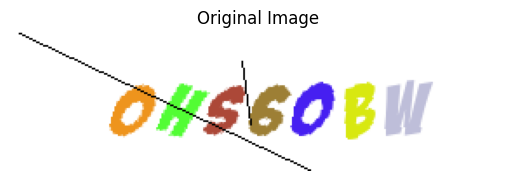

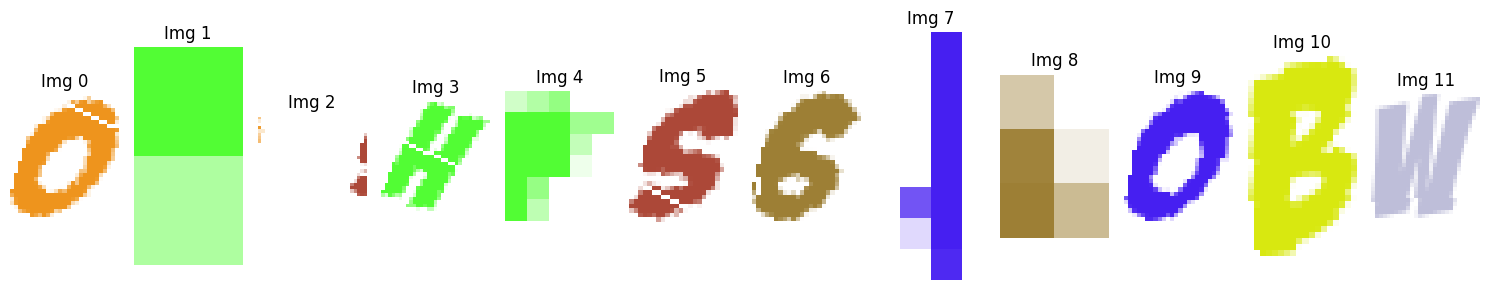

10


In [13]:
test_generate_char_dataset(True, True, 9)

In [14]:
img_path = "train/0hs60bw-0.png"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

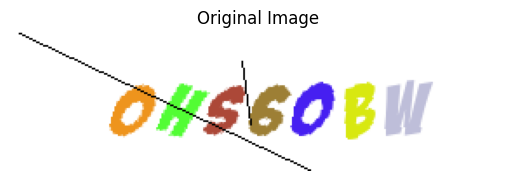

In [15]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis('off')
plt.title("Original Image")
plt.show()

In [16]:
r = temp(img, 0, color=True)

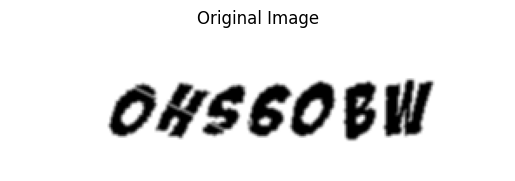

In [17]:
plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis('off')
plt.title("Original Image")
plt.show()

In [18]:
r = preprocess_image(img, color=True)

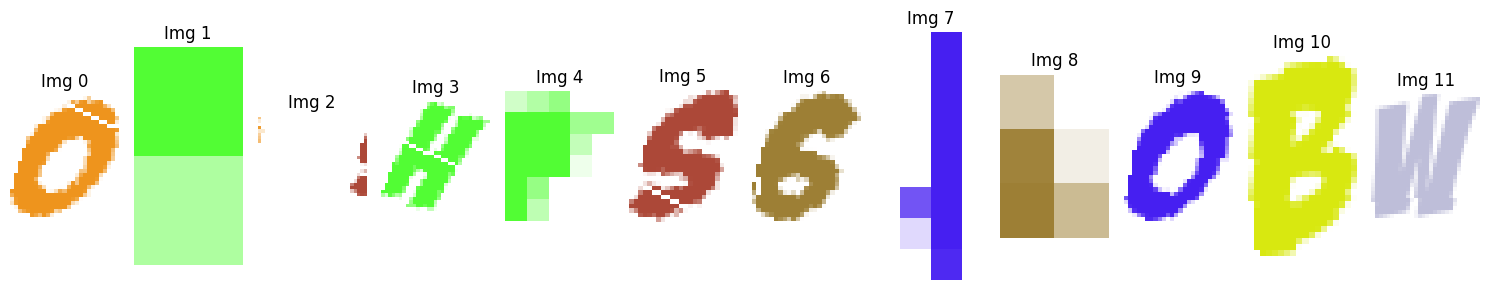

In [19]:
plt.figure(figsize=(15, 3))  # Adjust size as needed

for i, img in enumerate(r):
    plt.subplot(1, len(r), i + 1)
    # If using OpenCV images (BGR), convert to RGB
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Img {i}')

plt.tight_layout()
plt.show()

# Creating more dataset

In [20]:
def rotate_image(img, angle):
    # Get image center and rotation matrix
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate bounding box size to fit rotated image
    cos = np.abs(rot_matrix[0, 0])
    sin = np.abs(rot_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix for translation
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]

    # Perform rotation with white background
    if len(img.shape) == 2:
        border_value = 255
    else:
        border_value = (255, 255, 255)

    rotated = cv2.warpAffine(img, rot_matrix, (new_w, new_h), borderValue=border_value)

    return rotated

In [21]:
train_letter_dir = 'train_letter'

In [22]:
angles = [-30, -20, -10, 10, 20, 30]

In [23]:
from collections import defaultdict
filename_count = defaultdict(int)

In [24]:
from PIL import Image
import numpy as np
import os

def save_image_from_array(img_array, save_path):
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        # Convert BGR (OpenCV) to RGB (PIL)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    img = Image.fromarray(img_array.astype(np.uint8))
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img.save(save_path)

In [25]:
def generate_char_dataset():
    count = 0
    miscount = 0
    for filename in sorted(os.listdir(train_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue

            label = filename.split('-')[0]
            chars = preprocess_image(img, resize_to=None, color=False)


            if len(label) != len(chars):
                miscount += 1
                continue

            for i in range(min(len(label), len(chars))):
                letter = label[i]
                char = chars[i]
                new_name = 'img-' + str(filename_count[letter]) + '.png'
                filename_count[letter] += 1
                save_image_from_array(char, os.path.join(train_letter_dir, letter, new_name))
                random_numbers = random.sample(range(len(angles)), 3)              
                for no in random_numbers:
                    new_char = rotate_image(char, angles[no])
                    new_name ='img-' + str(filename_count[letter]) + '.png'
                    filename_count[letter] += 1
                    save_image_from_array(new_char, os.path.join(train_letter_dir, letter, new_name))

        count += 1
        if count % 500 == 0:
            print(f"Done with {count} files")

    print(miscount)

# Use the script to get the dataset

In [26]:
# generate_char_dataset()